In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv("data_preprocess_0629.csv")
df.head()

,step1,no_DM_Dx,no_DM_test,FHx,area,sex,age,glu0,glu60,glu120,...,AS1_AST_TR,AS1_ALT_TR,AS1_R_GTP_TR,AS1_TOTPRT,AS1_TOTBIL,AS1_CA,HB,AS1_HCT,SH_T,HbA1c_T
0,1,1,1,0,1,2,69.0,74.0,120.0,113.0,...,25.0,17.0,17.0,7.4,0.48,10.1,12.1,36.0,0,0
1,0,1,0,1,2,2,42.0,141.0,277.0,282.0,...,25.0,26.0,27.0,7.4,0.62,9.3,13.3,40.9,0,1
2,1,1,1,0,1,2,63.0,72.0,77.0,90.0,...,34.0,20.0,9.0,7.6,0.45,9.7,11.0,33.0,0,0
3,0,0,0,0,2,1,56.0,98.0,144.0,115.0,...,22.0,24.0,16.0,7.2,0.47,9.5,14.0,46.5,0,1
4,0,0,0,1,2,1,53.0,208.0,402.0,383.0,...,17.0,11.0,7.0,6.9,0.87,9.5,14.0,40.7,0,1


In [3]:
X = df.drop(['newDM'], axis=1)
y = df['newDM']

# filter Method

In [4]:
from skfeature.function.similarity_based import fisher_score

score = fisher_score.fisher_score(X.to_numpy(), y.to_numpy())
score = pd.Series(score)
score.index = X.columns
score= score.sort_values(ascending = False)

In [5]:
# fisher score로 구한 feature 집합 생성
fisher = score[:(len(X.columns)//2)].index
fisher

Index(['step1', 'area', 'no_DM_Dx', 'MetS', 'AS1_HEIGHT', 'AS1_INS0',
       'AS1_PLAT', 'HB', 'no_DM_test', 'glu120', 'AS1_ALBUMIN_TR',
       'AS1_CREATININE_TR', 'AS1_ALT_TR', 'AS1_BUN_TR', 'corisk', 'AS1_AST_TR',
       'HbA1c_T', 'AS1_TOTPRT', 'TG', 'AS1_INS60', 'SH_T', 'homa_b', 'glu0',
       'CRP', 'education', 'age', 'AS1_CA'],
      dtype='object')

# Wrapper method

In [6]:
# Step-wise feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split

# 모델 4가지 불러오기
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier

# 오버 샘플링을 위한 라이브러리
from imblearn.over_sampling import SMOTENC


In [7]:
selected_features = {}

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
categorical = [idx for idx, dtype in enumerate(X_train.dtypes) if dtype == 'int64']

# 오버 샘플링
smotenc = SMOTENC(categorical_features=categorical, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

# 분류기 생성
models = {
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(), 
    'SVC': SVC(),
    'SGDClassifier': SGDClassifier(),  
    #'CatBoostClassifier': CatBoostClassifier()
}

# Step-wise feature selection 수행
for key, model in models.items():
    feature_selector = SequentialFeatureSelector(estimator=model, direction='forward', )
    feature_selector.fit_transform(X_train_smotenc, y_train_smotenc) 
    selected_features[key] =feature_selector.get_feature_names_out()
# 선택된 특징 출력
print("Selected Features:")
print(selected_features)

c:\Users\AY\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
c:\Users\AY\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
c:\Users\AY\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprec

Selected Features:
{'LinearDiscriminantAnalysis': array(['step1', 'no_DM_Dx', 'no_DM_test', 'FHx', 'glu60', 'glu120',
       'HbA1c', 'eGFR', 'CRP', 'homa_ir', 'homa_b', 'marriage',
       'education', 'wcrisk', 'bprisk', 'Tchol', 'TG', 'AS1_INS60',
       'AS1_WBC', 'AS1_RBC', 'AS1_BUN_TR', 'AS1_ALT_TR', 'AS1_R_GTP_TR',
       'AS1_TOTBIL', 'HB', 'SH_T', 'HbA1c_T'], dtype=object), 'SVC': array(['step1', 'no_DM_Dx', 'no_DM_test', 'FHx', 'age', 'glu0', 'glu60',
       'glu120', 'HbA1c', 'eGFR', 'smoking', 'AS1_waist', 'AS1_hip',
       'AS1_BMI', 'AS1_WEIGHT', 'TG', 'HDL', 'AS1_INS0', 'AS1_INS60',
       'AS1_INS120', 'AS1_BUN_TR', 'AS1_AST_TR', 'AS1_ALT_TR', 'AS1_CA',
       'HB', 'AS1_HCT', 'HbA1c_T'], dtype=object), 'SGDClassifier': array(['step1', 'no_DM_Dx', 'sex', 'glu60', 'CRP', 'homa_ir', 'marriage',
       'education', 'drink', 'smoking', 'activity', 'AS1_WEIGHT',
       'corisk', 'bprisk', 'lipidrisk', 'TG', 'AS1_INS0', 'AS1_INS60',
       'AS1_INS120', 'AS1_WBC', 'AS1_RBC', '

In [8]:
selected_features

{'LinearDiscriminantAnalysis': array(['step1', 'no_DM_Dx', 'no_DM_test', 'FHx', 'glu60', 'glu120',
        'HbA1c', 'eGFR', 'CRP', 'homa_ir', 'homa_b', 'marriage',
        'education', 'wcrisk', 'bprisk', 'Tchol', 'TG', 'AS1_INS60',
        'AS1_WBC', 'AS1_RBC', 'AS1_BUN_TR', 'AS1_ALT_TR', 'AS1_R_GTP_TR',
        'AS1_TOTBIL', 'HB', 'SH_T', 'HbA1c_T'], dtype=object),
 'SVC': array(['step1', 'no_DM_Dx', 'no_DM_test', 'FHx', 'age', 'glu0', 'glu60',
        'glu120', 'HbA1c', 'eGFR', 'smoking', 'AS1_waist', 'AS1_hip',
        'AS1_BMI', 'AS1_WEIGHT', 'TG', 'HDL', 'AS1_INS0', 'AS1_INS60',
        'AS1_INS120', 'AS1_BUN_TR', 'AS1_AST_TR', 'AS1_ALT_TR', 'AS1_CA',
        'HB', 'AS1_HCT', 'HbA1c_T'], dtype=object),
 'SGDClassifier': array(['step1', 'no_DM_Dx', 'sex', 'glu60', 'CRP', 'homa_ir', 'marriage',
        'education', 'drink', 'smoking', 'activity', 'AS1_WEIGHT',
        'corisk', 'bprisk', 'lipidrisk', 'TG', 'AS1_INS0', 'AS1_INS60',
        'AS1_INS120', 'AS1_WBC', 'AS1_RBC', 'AS1_BU

In [9]:
common_features = set()

for key, features in selected_features.items():
    if len(common_features) == 0:
        common_features.update(features)
        print(common_features)


{'no_DM_Dx', 'AS1_WBC', 'homa_ir', 'marriage', 'SH_T', 'step1', 'AS1_ALT_TR', 'AS1_TOTBIL', 'HbA1c', 'AS1_RBC', 'AS1_R_GTP_TR', 'homa_b', 'glu120', 'no_DM_test', 'CRP', 'AS1_BUN_TR', 'FHx', 'glu60', 'TG', 'wcrisk', 'Tchol', 'bprisk', 'education', 'HB', 'AS1_INS60', 'HbA1c_T', 'eGFR'}


In [10]:
cols = list(common_features)
print(len(cols))
cols


27


['no_DM_Dx',
 'AS1_WBC',
 'homa_ir',
 'marriage',
 'SH_T',
 'step1',
 'AS1_ALT_TR',
 'AS1_TOTBIL',
 'HbA1c',
 'AS1_RBC',
 'AS1_R_GTP_TR',
 'homa_b',
 'glu120',
 'no_DM_test',
 'CRP',
 'AS1_BUN_TR',
 'FHx',
 'glu60',
 'TG',
 'wcrisk',
 'Tchol',
 'bprisk',
 'education',
 'HB',
 'AS1_INS60',
 'HbA1c_T',
 'eGFR']

In [63]:
select_X = X[cols]

In [ ]:
cols.append('newDM')
# 새로운 학습 데이터 csv 파일 생성
df[cols].to_csv('data_feature_select.csv', index=False)

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

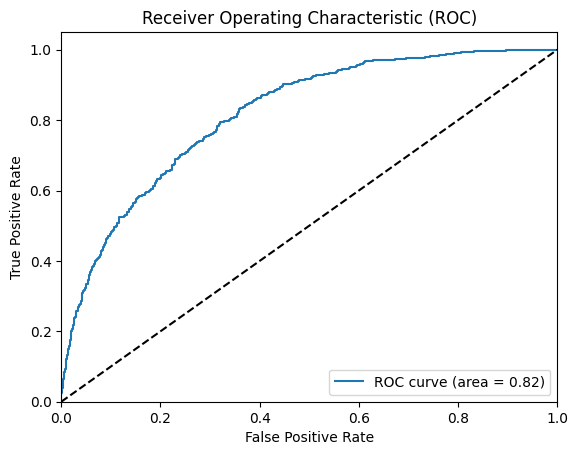

오차행렬:
 [[2453  130]
 [ 286  140]]

정확도: 0.8617
정밀도: 0.5185
재현율: 0.3286
F1: 0.4023
AUC: 0.6392


In [65]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(select_X , y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost 분류기 객체 생성
xgb_model = xgb.XGBClassifier()

# 모델 학습
xgb_model.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터에 대한 예측 수행 및 확률 예측
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 및 AUC 출력
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
get_clf_eval(y_test, y_pred)

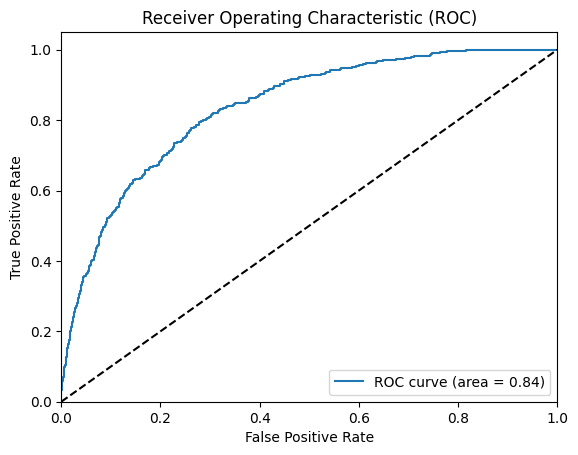

오차행렬:
 [[2445  138]
 [ 270  156]]

정확도: 0.8644
정밀도: 0.5306
재현율: 0.3662
F1: 0.4333
AUC: 0.6564


In [66]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()

lgb.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터에 대한 예측 수행 및 확률 예측
y_pred_proba = lgb.predict_proba(X_test)[:, 1]
y_pred = lgb.predict(X_test)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 및 AUC 출력
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
get_clf_eval(y_test, y_pred)

Learning rate set to 0.029755
0:	learn: 0.6773556	total: 6.3ms	remaining: 6.29s
1:	learn: 0.6608564	total: 12.2ms	remaining: 6.07s
2:	learn: 0.6461666	total: 18.7ms	remaining: 6.22s
3:	learn: 0.6341205	total: 24.6ms	remaining: 6.13s
4:	learn: 0.6206886	total: 29.9ms	remaining: 5.94s
5:	learn: 0.6104510	total: 35.8ms	remaining: 5.93s
6:	learn: 0.6015123	total: 41.2ms	remaining: 5.84s
7:	learn: 0.5916531	total: 46.4ms	remaining: 5.75s
8:	learn: 0.5810074	total: 52.7ms	remaining: 5.8s
9:	learn: 0.5707476	total: 57.7ms	remaining: 5.71s
10:	learn: 0.5630414	total: 63.1ms	remaining: 5.67s
11:	learn: 0.5560878	total: 69.7ms	remaining: 5.74s
12:	learn: 0.5499015	total: 75.1ms	remaining: 5.7s
13:	learn: 0.5439951	total: 80.1ms	remaining: 5.64s
14:	learn: 0.5384666	total: 86.3ms	remaining: 5.67s
15:	learn: 0.5334967	total: 92.1ms	remaining: 5.67s
16:	learn: 0.5289127	total: 97.6ms	remaining: 5.64s
17:	learn: 0.5246562	total: 103ms	remaining: 5.62s
18:	learn: 0.5195001	total: 108ms	remaining: 5.5

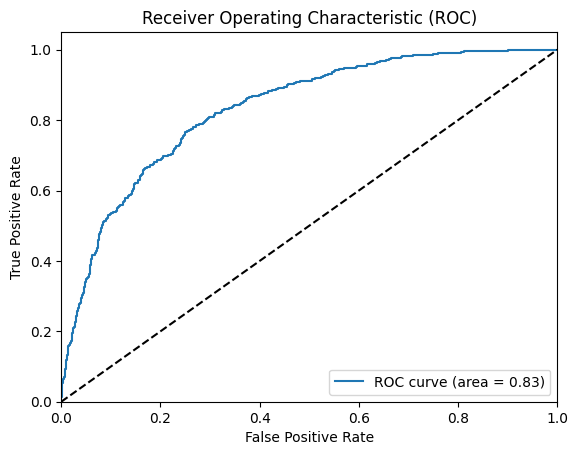

오차행렬:
 [[2453  130]
 [ 279  147]]

정확도: 0.8641
정밀도: 0.5307
재현율: 0.3451
F1: 0.4182
AUC: 0.6474


In [67]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier()

cat.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터에 대한 예측 수행 및 확률 예측
y_pred_proba = cat.predict_proba(X_test)[:, 1]
y_pred = cat.predict(X_test)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 및 AUC 출력
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
get_clf_eval(y_test, y_pred)